<h1><center>Code Executors in AutoGen</center></h1>
<hr><hr>
Code executors enable agents to not just chat but also to interact with an environment and perform useful computations and take actions.

- In AutoGen, a code executor is a component that takes input messages (e.g., those containing code blocks), performs execution, and outputs messages with the results.
- AutoGen provides two types of built-in code executors:
    - **Command line code executor**: It runs code in a command line environment such as a UNIX shell.
    - **Jupyter executor**: It runs code in an interactive Jupyter kernel.

__For each type of executor, AutoGen provides two ways to execute code__: locally and in a Docker container.
- One way is to **execute code directly in the same host platform where AutoGen is running**, i.e., the local operating system. It is for development and testing, but it is not ideal for production as LLM can generate arbitrary code.
- The other way is to **execute code in a Docker container**. The table below shows the combinations of code executors and execution environments.

<table><thead><tr><th>Code Executor (<code>autogen.coding</code>)</th><th>Environment</th><th>Platform</th></tr></thead><tbody><tr><td><a href="/autogen/docs/reference/coding/local_commandline_code_executor#localcommandlinecodeexecutor"><code>LocalCommandLineCodeExecutor</code></a></td><td>Shell</td><td>Local</td></tr><tr><td><a href="/autogen/docs/reference/coding/docker_commandline_code_executor#dockercommandlinecodeexecutor"><code>DockerCommandLineCodeExecutor</code></a></td><td>Shell</td><td>Docker</td></tr><tr><td><a href="/autogen/docs/reference/coding/jupyter/jupyter_code_executor#jupytercodeexecutor"><code>jupyter.JupyterCodeExecutor</code></a></td><td>Jupyter Kernel (e.g., python3)</td><td>Local/Docker</td></tr></tbody></table>

- <a href="https://microsoft.github.io/autogen/docs/tutorial/code-executors/" target="_blank">Command Line Code Executor Doc</a>
- <a href="https://microsoft.github.io/autogen/docs/topics/code-execution/jupyter-code-executor/" target="_blank">Jupyter Code Executor Doc</a>

### Configuration:
---------------------

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_api_key = os.getenv("AZURE_OPENAI_KEY")
azure_openai_api_version = "2023-05-15"
llm_deployment_name = os.getenv("GPT_DEPLOYMENT_NAME")

os.environ["OPENAI_API_TYPE"]     = "azure"
os.environ["OPENAI_API_VERSION"]  = azure_openai_api_version
os.environ["OPENAI_API_KEY"]      = azure_openai_api_key

## Local Execution:
----------------------
The figure below shows the architecture of the local command line code executor (`autogen.coding.LocalCommandLineCodeExecutor`).

<center><img src="./images/004-command-line-code-executor.png" /></center>

Upon receiving a message with a code block:
1. The local command line code executor first writes the code block to a code file.
2. It then starts a new subprocess to execute the code file.
3. The executor reads the console output of the code execution and sends it back as a reply message.

Here is an example of using the code executor to run a Python code block that prints a random number. <br>
First we create an agent with the code executor that uses a temporary directory to store the code files. <br>
We specify `human_input_mode="ALWAYS"` to manually validate the safety of the the code being executed.

In [4]:
import tempfile
from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

In [9]:
# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

In [10]:
print( temp_dir.name )

C:\Users\DEBANJ~1\AppData\Local\Temp\tmpw4dwywbz


In [11]:
# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

- Now we have the agent generate a reply given a message with a Python code block.

In [17]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x, y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)

Provide feedback to the sender. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



During the generation of response, a human input is requested to give an opportunity to intercept the code execution. In this case, we choose to continue the execution, and the **agent’s reply contains the output of the code execution**.

We can take a look at the generated plot in the temporary directory.

In [19]:
print(os.listdir(temp_dir.name))
# We can see the output scatter.png and the code file generated by the agent.

['scatter.png', 'tmp_code_e24bf32d4a21990fb9e4b5eb889ebe5a.py']


In [20]:
# Clean up the working directory to avoid affecting future conversations.
temp_dir.cleanup()

## Docker Execution:
---------------------
- To mitigate the security risk of running LLM-generated code locally, we can use the docker command line code executor (`autogen.coding.DockerCommandLineCodeExecutor`) to execute code in a docker container.
- This way, the generated code can only access resources that are explicitly given to it.

The figure below illustrates how does the docker execution works.
<center><img src="./images/005-code-executor-docker.png" /></center>

- Similar to the local command line code executor, the docker executor extracts code blocks from input messages, writes them to code files.
- For each code file, it starts a docker container to execute the code file, and reads the console output of the code execution.

To use docker execution, you need to install Docker on your machine. Once you have Docker installed and running, you can set up your code executor agent as follow:

In [21]:
from autogen.coding import DockerCommandLineCodeExecutor

# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

# Create a Docker command line code executor.
docker_executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",  # Execute code using the given docker image name.
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration that uses docker.
code_executor_agent_using_docker = ConversableAgent(
    "code_executor_agent_docker",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": docker_executor},  # Use the docker command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

- Install required packages in the container (ex- Numpy, Matplotlib) and then run the code block below:

In [23]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x, y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent_using_docker.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)

Provide feedback to the sender. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



In [24]:
# When the code executor is no longer used, stop it to release the resources.
docker_executor.stop()

### NOTE:
------------
- The `work_dir` in the constructor points to a local file system directory just like in the local execution case. The docker container will mount this directory and the executor write code files and output to it.

<center><h1>Using Code Execution in Conversation</h1></center>
<hr><hr>
Writing and executing code is necessary for many tasks such as data analysis, machine learning, and mathematical modeling. In AutoGen, coding can be a conversation between a code writer agent and a code executor agent, mirroring the interaction between a programmer and a code interpreter.
<center><img src="./images/006-code-execution-in-conversation.png"/></center>

The code writer agent can be powered by an LLM such as GPT-3.5 or GPT-4 with code-writing capability. And the code executor agent is powered by a code executor.

The following is an agent with a code writer role specified using system_message. The system message contains important instruction on how to use the code executor in the code executor agent.

In [29]:
from pathlib import Path
from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

In [25]:
llm_config_list = [
    {
        'model' : llm_deployment_name,
        # "temperature": 0.7,
        'api_key': azure_openai_api_key,
        'base_url' : azure_endpoint,
        'api_type' : 'azure',
        'api_version' : azure_openai_api_version
    }
]

# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config={"config_list": llm_config_list},
    code_execution_config=False,  # Turn off code execution for this agent.
)

In [28]:
work_dir = Path("autogen_coding")
work_dir.mkdir(exist_ok=True)

print( work_dir )

autogen_coding


In [37]:
# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    # work_dir=work_dir,  
    work_dir=temp_dir.name# Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

- Here is an example of solving a math problem through a conversation between the code writer agent and the code executor agent (created above).

In [31]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer_agent):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To calculate the 14th Fibonacci number, you can use a simple loop or recursion. Here's an example of how you can do it using a loop:

```python
# calculate the 14th Fibonacci number
n = 14

# initialize the first two numbers in the sequence
fibonacci = [0, 1]

# calculate the Fibonacci sequence up to the n-th number
for i in range(2, n+1):
    fibonacci.append(fibonacci[i-1] + fibonacci[i-2])

# get the 14th Fibonacci number
fibonacci_14th = fibonacci[n]

print(f"The 14th Fibonacci number is: {fibonacci_14th}")
```

Executing this code will output: "The 14th Fibonacci number is: 377".

Please note that the Fibonacci sequence starts with 0 and 1, so the 14th Fibonacci number is the 13th element in the sequence.

-------------------

Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
code_executor_agent (to code_writer_agent):

exitcode: 0 (execution succeeded)
Code output: The 14th Fibonacci number is: 377


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

Great! The code successfully calculated the 14th Fibonacci number, which is 377. If you have any more questions or need further assistance, feel free to ask.

--------------------------------------------------------------------------------


Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_executor_agent (to code_writer_agent):



--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

I'm glad I could assist you! If you have any more questions or need help with anything else, feel free to ask. I'm here to help!

--------------------------------------------------------------------------------


Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  exit


<hr>
- During the above chat session, human input was requested each time the code executor agent responded to ensure that the code was safe to execute.
<hr>

Now we can try a more complex example that involves querying the web. <br>
Let’s say we want to get the the stock price gains year-to-date for Tesla and Meta (formerly Facebook). We can also use the two agents with several iterations of conversation.

In [38]:
import datetime

today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-03-22. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To plot the stock price gains YTD for TSLA and META, we need to first collect the historical stock prices for the two companies. We can use the yfinance library in Python to collect the stock price data. Then, we can calculate the cumulative gain for each stock since the beginning of the year and plot the results using the matplotlib library. Here's the Python code to accomplish this task:

```python
# filename: stock_gains.py
import matplotlib.pyplot as plt
import yfinance as yf

# Define the ticker symbols for TSLA and META
tickers = ['TSLA', 'META']

# Download the historical stock price data
data = yf.download(tickers, start='2024-01-01', end='2

Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING 3 CODE BLOCKS (inferred languages are [python, sh, sh])...
code_executor_agent (to code_writer_agent):

exitcode: 1 (execution failed)
Code output: 
[                       0%%                      ]
[*********************100%%**********************]  2 of 2 completed
C:\Users\Debanjan : The term 'C:\Users\Debanjan' is not recognized as the name of a cmdlet, function, script file, or 
operable program. Check the spelling of the name, or if a path was included, verify that the path is correct and try 
again.
At line:1 char:1
+ C:\Users\Debanjan Sarkar\AppData\Local\Temp\tmpkem5f6x8\tmp_code_3720 ...
+ ~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (C:\Users\Debanjan:String) [], CommandNotFoundException
    + FullyQualifiedErrorId : CommandNotFoundException
 


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent

Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  exit


- Let’s take a look at the chart that was generated.

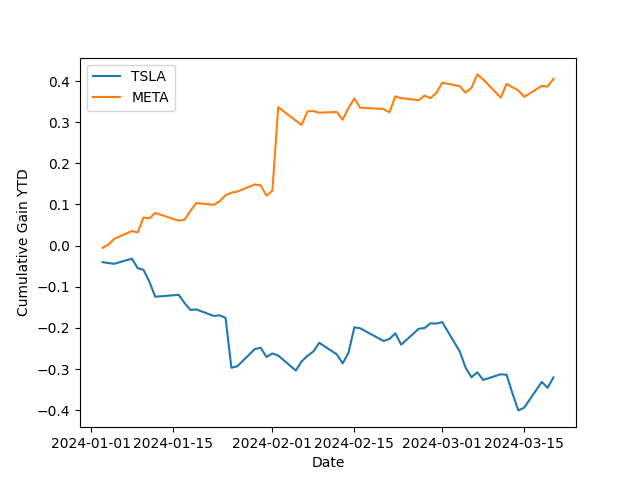

In [40]:
from IPython.display import Image

Image(os.path.join(temp_dir.name, "stock_gains.png"))

- Because code execution leave traces like code files and output in the file system, we may want to clean up the working directory after each conversation concludes.

In [41]:
temp_dir.cleanup()

In [43]:
executor.stop()  # Stop the docker command line code executor, if the executor is a Docker Executor.

AttributeError: 'LocalCommandLineCodeExecutor' object has no attribute 'stop'

## Command Line v/s Jupyter Code Executor:
--------------------------------------------
- The command line code executor does not keep any state in memory between executions of different code blocks it receives, as it writes each code block to a separate file and executes the code block in a new process.

- Contrast to the command line code executor, the Jupyter code executor runs all code blocks in the same Jupyter kernel, which keeps the state in memory between executions. See the topic page for Jupyter Code Executor.

- The choice between command line and Jupyter code executor depends on the nature of the code blocks in agents’ conversation.
    - If each code block is a “script” that does not use variables from previous code blocks, the command line code executor is a good choice.
    - If the some code blocks contain expensive computation (e.g., training a machine learning model and loading large amount of data), and you want to keep the state in memory to avoid repeated computation, the Jupyter code executor is a better choice.

# Note on User Proxy Agent and Assistant Agent:
-------------------------------------------------


## User Proxy Agent:
---------------------
- In the previous examples, we create the code executor agent directly using the `ConversableAgent` class.
- Existing AutoGen examples often create code executor agent using the `UserProxyAgent` class, **which is a subclass of `ConversableAgent`** with `human_input_mode=ALWAYS` and `llm_config=False` – it always requests human input for every message and does not use LLM.
- It also comes with default `description` field for each of the `human_input_mode` setting.
- This class is a convenient short-cut for creating an agent that is ***intended to be used as a code executor***.

## Assistant Agent:
---------------------
- In the previous examples, we created the code writer agent directly using the `ConversableAgent` class. Existing AutoGen examples often create the code writer agent using the `AssistantAgent` class, **which is a subclass of `ConversableAgent`** with `human_input_mode=NEVER` and `code_execution_config=False` – it never requests human input and does not use code executor.
- It also comes with default `system_message` and `description` fields.
- This class is a convenient short-cut for creating an agent that is ***intended to be used as a code writer and does not execute code***.

- In fact, in the previous example we use the default `system_message` field of the `AssistantAgent` class to instruct the code writer agent how to use code executor.

In [44]:
import pprint
from autogen import AssistantAgent

pprint.pprint(AssistantAgent.DEFAULT_SYSTEM_MESSAGE)

('You are a helpful AI assistant.\n'
 'Solve tasks using your coding and language skills.\n'
 'In the following cases, suggest python code (in a python coding block) or '
 'shell script (in a sh coding block) for the user to execute.\n'
 '    1. When you need to collect info, use the code to output the info you '
 'need, for example, browse or search the web, download/read a file, print the '
 'content of a webpage or a file, get the current date/time, check the '
 'operating system. After sufficient info is printed and the task is ready to '
 'be solved based on your language skill, you can solve the task by yourself.\n'
 '    2. When you need to perform some task with code, use the code to perform '
 'the task and output the result. Finish the task smartly.\n'
 'Solve the task step by step if you need to. If a plan is not provided, '
 'explain your plan first. Be clear which step uses code, and which step uses '
 'your language skill.\n'
 'When using code, you must indicate the scrip

# Best Practice:
----------------------
- It is very important to note that the `UserProxyAgent` and `AssistantAgent` are meant to be shortcuts to avoid writing the `system_message` instructions for the `ConversableAgent` class.
- They are not suitable for all use cases.
- Tuning the `system_message` field is vital for agent to work properly in more complex conversation patterns beyond two-agent chat.

**As a best practice**, always tune your agent’s `system_message` instructions for your specific use case and avoid subclassing `UserProxyAgent` and `AssistantAgent`.

<hr><hr>